## Week 2-2 - Visualizing General Social Survey data

Your mission is to analyze a data set of social attitudes by turning it into vectors, then visualizing the result.

### 1. Choose a topic and get your data

We're going to be working with data from the General Social Survey, which asks Americans thousands of questions ever year, over decades. This is an enormous data set and there have been very many stories written from its data. The first thing you need to do is decide which questions and which years you are going to try to analyze.

Use their [data explorer](https://gssdataexplorer.norc.org/) to see what's available, and ultimately download an Excel file with the data. 

- Click the `Search Varibles` button.
- You will need at least a dozen or two related variables. Try selecting some using their `Filter by Module / Subject` interface.
- When you've made your selection, click the `+ All` button to add all listed variables, then choose `Extract Data` under the `Actions` menu.
- Then you have a multi-step process. Step 1 is just naming your extract
- Step 2: select variables *again!* Click `Add All` in the upper right of the "Variable Cart" in the "Choose Variables" step.
- Step 3: Skip it. You could use this to filter the data in various ways. 
- Step 4: Click `Select certain years` to pick one year of data, then check `Excel Workbook (data + metadata)` as the output format.
- Click `Create Extract` and wait a minute or two on the "Extracts" page until the spinner stops and turns into a download link.

You'll end up with an compressed file in tar.gz format, which you should be able to decompressed by double-clicking on it. Inside is an Excel file. Open it in Excel (or your favorite spreadsheet program) and resave it as a CSV.





In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math
%matplotlib inline


In [2]:
# load your data set here
gss = pd.read_csv('week-2/gss/Data-Table 1.csv', sep=';')
gss.head()

,Age of respondent,Rs religious preference,How fundamentalist is r currently,Religion in which raised,Tried to convince others to accept jesus,Is homosexual sex wrong?
0,49,Catholic,Moderate,Catholic,Yes,Always wrong
1,48,Protestant,Liberal,Protestant,No,Not applicable
2,47,None,Liberal,Protestant,No,Not wrong at all
3,32,Protestant,Fundamentalist,Protestant,Yes,Almost always wrong
4,37,Protestant,Fundamentalist,Catholic,Yes,Not applicable


### 3. Turn people  into vectors
I know, it sounds cruel. We're trying to group people, but computers can only group vectors, so there we are. 

Translating the spreadsheet you downloaded from GSS Explorer into vectors is a multistep process. Generally, each row of the spreadsheet is one person, and each column is one qeustion. 

- First, we need to throw away any extra rows and columns: headers, questions with no data, etc.
- Many GSS questions already have numerical answers. These usually don't require any work.
- But you'll need to turn categorical variables into numbers.

Basically, you have to remove or convert every value that isn't a number. Because this is survey data, we can turn most questions into an integer scale. The cleanup might use functions like this:

In [3]:
# drop the last two rows, which are just notes and do not contain data
gss = gss.iloc[0:-3,:]


In [52]:
# Here's a bunch of cleanup code. It probably won't be quite right for your data.
# The goal is to convert all values to small integers, to make them easy to plot with colors below.

# First, replace all of the "Not Applicable" values with None
gss = gss.replace({'Not applicable' : None, 
                   'No answer' : None, 
                   'Don\'t know' : None,
                   'Dont know' : None,
                   'Na-excluded': None
                   })

# Manually code likert scales 
gss = gss.replace({'Strongly disagree':-2, 'Disagree':-1, 'Neither agree nor disagree':0, 'Agree':1, 'Strongly agree':2})

# Replacement for homosex1 question
gss = gss.replace({
  'Always wrong': -2,
  'Almost always wrong': -1,
  'Wrong only sometimes': 0,
  'Not wrong at all': 1,
})

# Replacement for fundamentalism
gss = gss.replace({
  'Fundamentalist': -1,
  'Moderate': 0,
  'Liberal': 1
})

# Replacement for religion
gss = gss.replace({
  'None': 0,
  'Protestant': 1,
  'Catholic': 2,
  'Moslem/islam': 3,
  'Jewish': 4,
  'Other': 5,
  'Buddhism': 6,
  'Hinduism': 7,
  'Other eastern': 8,
  'Orthodox-christian': 9,
  'Christian': 10,
  'Native american': 11,
  'Inter-nondenominational': 12
})

# yes/no -> 1/-1
gss = gss.replace({'Yes':1, 'No':-1})

# Some frequency scales should have numeric coding too
gss = gss.replace({'Not at all in the past year' : 0, 
            'Once in the past year' : 1,
            'At least 2 or 3 times in the past year' : 2, 
            'Once a month' : 3,
            'Once a week' : 4,
            'More than once a week':5}) 

gss = gss.replace({ 'Never or almost never' : 0, 
                    'Once in a while' : 1,
                    'Some days' : 2, 
                    'Most days' : 3,
                    'Every day' : 4,
                    'Many times a day' : 5}) 

gss = gss.replace({
  '89 or older': 89
})
# Drop some columns that don't contain useful information
# Already removed that from CSV

# Turn invalid numeric entries into zeros
gss = gss.replace({np.nan:0.0})


In [5]:
gss.head()

,Age of respondent,Rs religious preference,How fundamentalist is r currently,Religion in which raised,Tried to convince others to accept jesus,Is homosexual sex wrong?
0,49,2.0,0.0,2.0,1.0,-2.0
1,48,1.0,1.0,1.0,-1.0,0.0
2,47,0.0,1.0,1.0,-1.0,1.0
3,32,1.0,-1.0,1.0,1.0,-1.0
4,37,1.0,-1.0,2.0,1.0,0.0


### 4. Plot those vectors!
For this assignment, we'll use the PCA projection algorithm to make 2D (or 3D!) pictures of the set of vectors. Once you have the vectors, it should be easy to make a PCA plot using the steps we followed in class.
    

In [47]:
# make a PCA plot here
model = PCA(n_components=2)

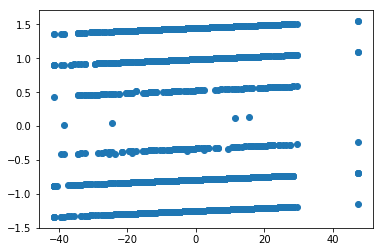

In [48]:


out = model.fit_transform(gss[['Tried to convince others to accept jesus',
                               'Age of respondent',
                              'How fundamentalist is r currently']])
plt.scatter(out[:, 0], out[:, 1])
plt.show()


### 5. Add color to help interpretation
Congratulations, you have a picture of a blob of dots. Hopefully, that blob has some structure representing clusters of similar people. To understand what the plot is telling us, it really helps to take one of the original variables and use it to assign colors to the points. 

So: pick one of the questions that you think will separate people into natural groups. Use it to set the color of the dots in your scatterplot. By repeating this with different questions, or combining questions (like two binary questions giving rise to a four color scheme) you should be able to figure out what the structure of the clusters represents. 


In [9]:
# map integer columns to colors
def col2colors(colvals):
    # gray for zero, then a rainbow.
    # This is set up so yes = 1 = red and no = -1 = indigo
    my_colors = ['gray', 'red','orange','yellow','lightgreen','cyan','blue','indigo']
    
    # We may have integers higher than len(my_colors) or less than zero
    # So use the mod operator (%) to make values "wrap around" when they go off the end of the list
    column_ints = colvals.astype(int) % len(my_colors)
    
    # map each index to the corresponding color
    return column_ints.apply(lambda x: my_colors[x])



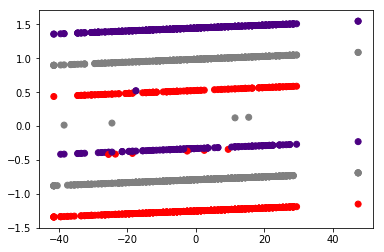

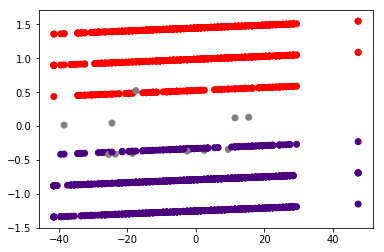

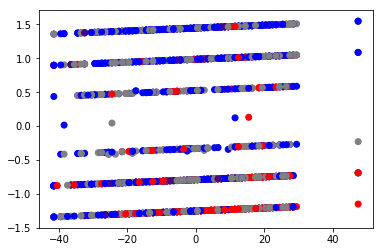

In [51]:
# Make a plot using colors from a particular column
# religion_colors = col2colors(gss['Rs religious preference'])
# plt.scatter(out[:, 0], out[:, 1], c=religion_colors)
# plt.show()

# Make another plot using colors from another column
fundamentalist_colors = col2colors(gss['How fundamentalist is r currently'])
# indigo = fundamentalist; grey = moderate; red = liberal
plt.scatter(out[:, 0], out[:, 1], c=fundamentalist_colors)
plt.show()

jesus_colors = col2colors(gss['Tried to convince others to accept jesus'])
# red = yes; indigo = no
plt.scatter(out[:, 0], out[:, 1], c=jesus_colors)
plt.show()

# ... repeat and see if you can figure out what each axis means
gaysex_colors = col2colors(gss['Is homosexual sex wrong?'])
# red = not wrong at all; grey = sometimes wrong; indigo = almost alwways wrong
plt.scatter(out[:, 0], out[:, 1], c=gaysex_colors)
plt.show()

In [14]:
# Eh, I have no idea what's that supposed to be. Let's try something else

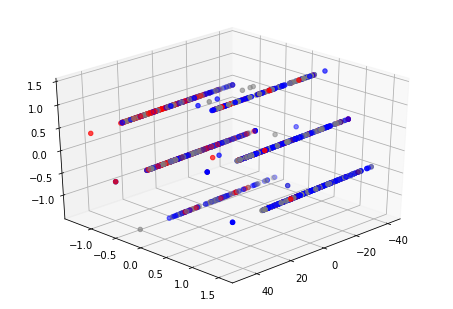

In [42]:
from mpl_toolkits.mplot3d import Axes3D

model = PCA(n_components=3)
out = model.fit_transform(gss[['Tried to convince others to accept jesus',
                               'Age of respondent',
                               'How fundamentalist is r currently']])
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(elev=30, azim=45)

ax.scatter(out[:, 0], out[:, 1], out[:, 2], c=fundamentalist_colors)


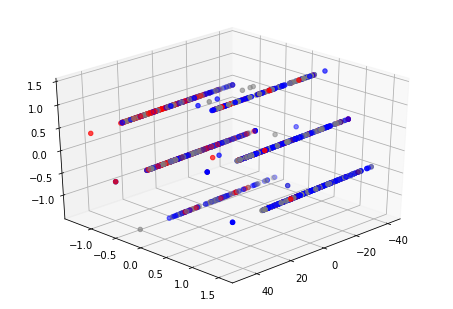

In [45]:


fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(elev=30, azim=45)
ax.scatter(out[:, 0], out[:, 1], out[:, 2], c=jesus_colors)


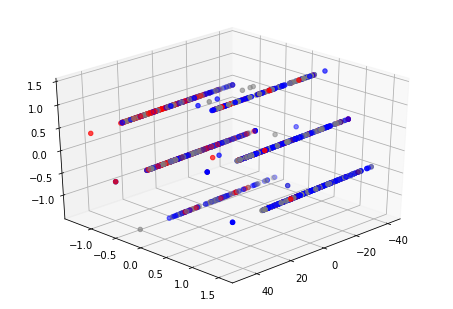

In [46]:
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(elev=30, azim=45)
ax.scatter(out[:, 0], out[:, 1], out[:, 2], c=gaysex_colors)


### 6. Tell us what it means?
What did you learn from this exercise? Did you find the standard left-right divide? Or urban-rural? Early adopters vs. luddites? People with vs. without children? 

What did you learn? What could end up in a story? 


Okay, I might not have had the best dataset, or chose the right amount of 
variables, which might explain why I didn't relly get nice clusters.

The initial assumption that more fundamentalist, evangelical people will condemn gay does only hold up barely – there is a slight difference in the coloration in the different groups, but even more moderate and liberal respondents seem to hold a negative view of gay sex.

I wonder how much the poll design plays into this – out of the four possible answers, three of them are various shades of "gay sex is wrong". Given the human tendency not to go for extremes in questionnaires and trying to "please" the interviewer, there might be a bias that nudged them to the "neutral" option – "only wrong sometimes" (which, of course, is still "wrong").